# Word Detection
Finding bounding boxes of words

## Import Packages

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from ocr.helpers import implt, resize, ratio

%matplotlib inline

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("Pandas: " + pd.__version__)

plt.rcParams['figure.figsize'] = (9.0, 9.0)

OpenCV: 3.1.0
Numpy: 1.13.1
Pandas: 0.20.3


### Global Variables

In [128]:
IMG = "poster"               # Image name/number

# Finding the text areas and words

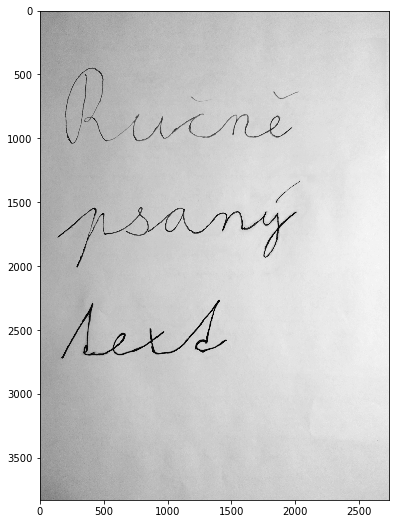

In [129]:
# Loading image (converting to RGB)
image = cv2.cvtColor(cv2.imread("data/textdet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
implt(img, 'gray')

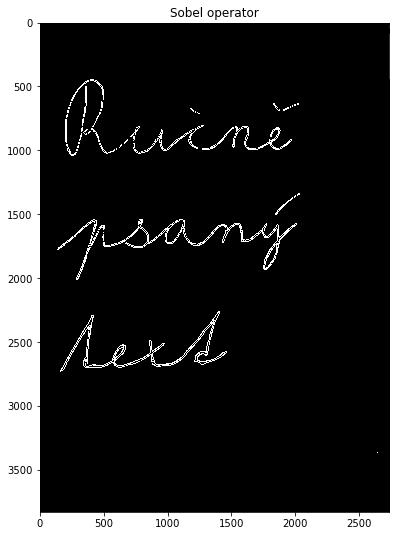

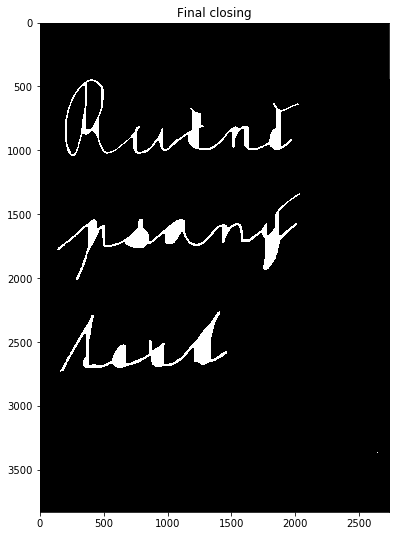

In [130]:
def sobelDetect(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def edgeDetect(im):
    """ 
    Edge detection 
    The Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([sobelDetect(im[:,:, 0]), sobelDetect(im[:,:, 1]), sobelDetect(im[:,:, 2]) ]), axis=0)

# Image pre-processing - blur, edges, threshold, closing
blurred = cv2.GaussianBlur(image, (5, 5), 18)
edgeImg = edgeDetect(blurred)
ret, edgeImg = cv2.threshold(edgeImg, 50, 255, cv2.THRESH_BINARY)
bwImage = cv2.morphologyEx(edgeImg, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))

implt(edgeImg, 'gray', 'Sobel operator')
implt(bwImage, 'gray', 'Final closing')

In [131]:
## NOT IN USE, NEED MORE WORK ##
def delLines(gray):
    """ Delete page lines """
    linek = np.ones((1,11),np.uint8)
    x = cv2.morphologyEx(gray, cv2.MORPH_OPEN, linek ,iterations=1)
    i = gray-x
    closing = cv2.morphologyEx(dil, cv2.MORPH_CLOSE, np.ones((17,17), np.uint8))
    implt(closing, 'gray', 'Del Lines')
    return closing


def delBigAreas(img):
    """ Find and remove contours too big for a word """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # ret, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 3)    
    implt(gray, 'gray')
    
    gray2 = gray.copy()
    mask = np.zeros(gray.shape,np.uint8)
    
    im2, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        if (200 < cv2.contourArea(cnt) < 5000):
            cv2.drawContours(img,[cnt],0,(0,255,0),2)
            cv2.drawContours(mask,[cnt],0,255,-1)
            
    implt(mask)
    implt(img)

## Word Detection

In [132]:
def textDetect(img, original):
    """ Text detection using contours """
    # Resize image
    small = resize(img, 2000)
    image = resize(original, 2000)
    
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    im2, cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    implt(img, 'gray')
    
    # Variables for contour index and words' bounding boxes
    index = 0    
    boundingBoxes = np.array([0,0,0,0])
    
    # CCOMP hierarchy: [Next, Previous, First Child, Parent]
    # cv2.RETR_CCOMP - contours into 2 levels
    # Go through all contours in first level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        # Get only the contour
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text (white pixel ratio, width, height)
        # TODO Test h/w and w/h ratios
        if r > 0.1 and 2000 > w > 10 and 1600 > h > 10 and h/w < 3 and w/h < 10:
            cv2.rectangle(image, (x, y),(x+w,y+h), (0, 255, 0), 8)
            boundingBoxes = np.vstack((boundingBoxes, np.array([x, y, x+w, y+h])))
        
        # Index of next contour
        index = hierarchy[0][index][0]
        
    implt(image, t='Bounding rectangles')

    # Recalculate coordinates to original scale
    bBoxes = boundingBoxes.dot(ratio(image, 2000)).astype(np.int64)
    return bBoxes[1:]  

## Watershed Algorithm

In [133]:
def textDetectWatershed(thresh, original):
    """ Text detection using watershed algorithm """
    # According to: http://docs.opencv.org/trunk/d3/db4/tutorial_py_watershed.html
    img = resize(original, 3000)
    thresh = resize(thresh, 3000)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers += 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    markers = cv2.watershed(img, markers)
    implt(markers, t='Markers')
    image = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Creating result array
    boundingBoxes = np.array([0,0,0,0])
    
    for mark in np.unique(markers):
        # mark == 0 --> background
        if mark == 0:
            continue

        # Draw it on mask and detect biggest contour
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[markers == mark] = 255

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(cnts, key=cv2.contourArea)
        
        # Draw a bounding rectangle if it contains text
        x,y,w,h = cv2.boundingRect(c)
        cv2.drawContours(mask, c, 0, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if r > 0.1 and 2000 > w > 15 and 1500 > h > 15:
            cv2.rectangle(image, (x, y),(x+w,y+h), (0, 255, 0), 2)
            boundingBoxes = np.vstack((boundingBoxes, np.array([x, y, x+w, y+h])))
        
    implt(image)

    # Recalculate coordinates to original size
    bBoxes = boundingBoxes.dot(ratio(original, 3000)).astype(np.int64)
    return bBoxes[1:]  

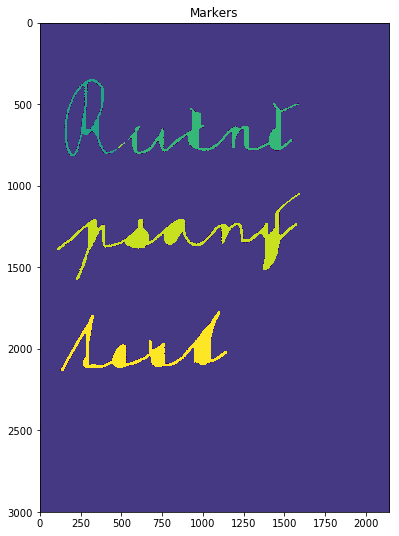

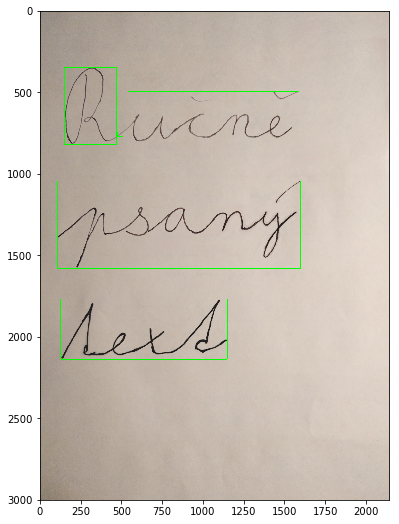

5


In [134]:
# Testing different alg - Watershed
wbBoxes = textDetectWatershed(bwImage, image)
print(len(wbBoxes))

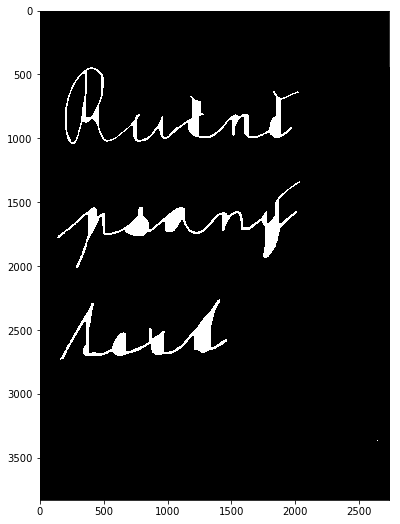

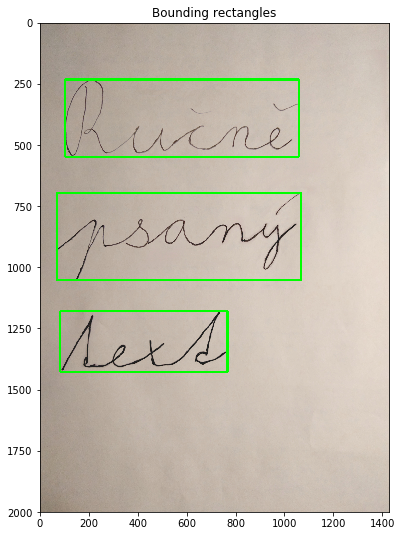

3


In [135]:
# Get text bounding boxes
bBoxes = textDetect(bwImage, image)
print(len(bBoxes))